# Integrate-and-fire neural model

## Parameters

The following section installs package dependencies and allows you to modify the parameters of the neural integration model, as-well-as parameters of the inputs (spike trains) to the model.

In [1]:
# Package dependencies
import numpy as np
import matplotlib.pyplot as plt

# Parameters
secs = 10  # seconds
dt = 0.01  # time step
C = 1  # membrane capacitance
Vm = -65  # resting initial potential [mV]

# Spiking inputs parameters
spikes_per_second = 20  # poisson incidence rate
tau = 1  # relaxation coefficient
inputs_count = 50  # how many input spike trains to model
synaptic_strength = 1.0  # input current peak for each spike

## Inputs

The following section pre-allocates the input events; i.e. it simulates incoming spike-trains using Poisson distributions. These can be modified by the parameters in the previous section.

In [2]:
# Pre-allocate memory
timespan = np.arange(0, secs, dt)  # time vector
V = np.zeros(timespan.shape)  # voltage vector
I = np.zeros(timespan.shape)  # current input vector
lam = 1/(spikes_per_second*dt)  # poisson lambda parameter
V[0] = Vm

# Pre-populate incoming spike times
inputs = []
map_inputs = np.ndarray((timespan.size, inputs_count), dtype='bool')
rng = np.random.default_rng()
for n in range(inputs_count):
    # spike times are poisson distributed (calculated in samples)
    last_spike = 0
    spike_times = []
    while last_spike < timespan.size:
        delay = rng.poisson(lam)
        spike_times.append(last_spike + delay + 1)
        last_spike = spike_times[-1]
    spike_times = spike_times[:-1]
    # add to raster for plotting
    map_inputs[[k in spike_times for k in range(timespan.size)], n] = True
    # convert spike_times to time (secs)
    spike_times = timespan[spike_times]
    inputs.append(type('bouton', (object,), {'spike_times': spike_times})())

## Model

The following section performs the main integration step of the neural model

In [3]:
# Euler integration of membrane potential
spike_times = []
for t in range(len(timespan[:-1])):
    # Determine input current from all inputs
    I[t] = 0.0
    for input in inputs:
        # Form decaying synaptic response from each spike - this could be more accurately modelled
        for spike_time in input.spike_times:
            I[t] += (
                synaptic_strength
                * (timespan[t] - spike_time) * np.heaviside(timespan[t] - spike_time, 1.0)
                * np.exp(-(timespan[t] - spike_time) / tau)
            )

    # Forward Euler integration
    dVdt = (-(V[t] - Vm) + I[t]/C)/tau
    V[t+1] = V[t] + dt*dVdt

    # Reset voltage
    if V[t+1] > 0:
        spike_times.append(timespan[t])
        V[t+1] = Vm

# Plotting

This sections plots the results, and displays some summary metrics.

Output spike rate over the last 5.0 seconds: 11.2 Hz


/var/folders/rm/ccvwg7qj52g56qps5583_0kr0000gn/T/ipykernel_90976/328179204.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


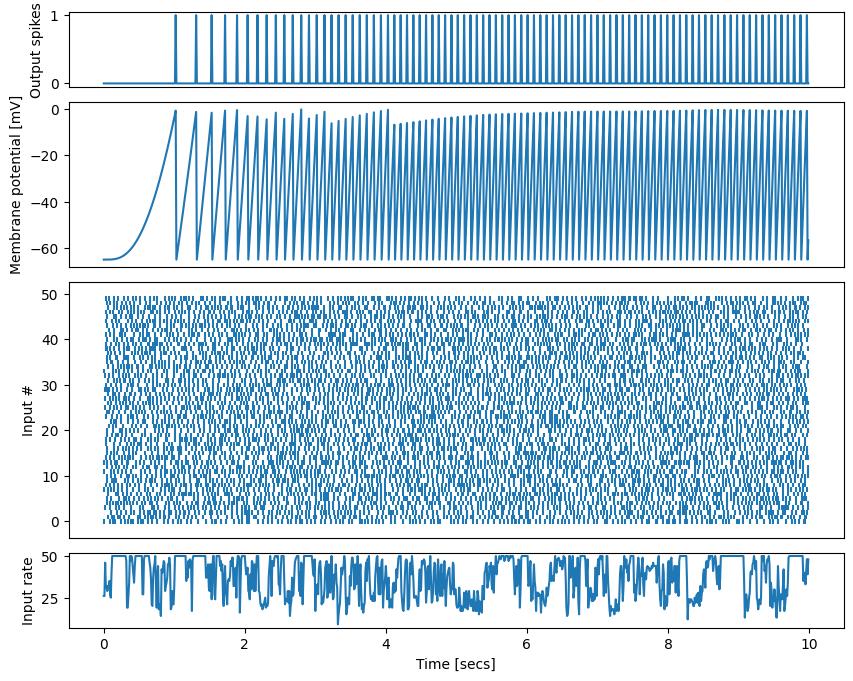

In [10]:
# Plot results
fig, axs = plt.subplot_mosaic(
    [['a'], ['b'], ['b'], ['c'], ['c'], ['c'], ['d']],
    figsize=(10, 8),
)
axs['a'].plot([k*dt in spike_times for k in range(timespan.size)])
axs['a'].set_ylabel('Output spikes')
axs['a'].set_xticks([])
axs['b'].plot(timespan, V)
axs['b'].set_ylabel('Membrane potential [mV]')
axs['b'].set_xticks([])
axs['c'].eventplot([b.spike_times for b in inputs])
axs['c'].set_xticks([])
axs['c'].set_ylabel('Input #')
axs['d'].plot(timespan, np.sum(map_inputs, axis=1))
axs['d'].set_ylabel('Input rate')
axs['d'].set_xlabel('Time [secs]')
fig.show()

# Display some metrics
span_secs = 5.
spikes_in_last_second = np.sum([1 for s in spike_times if s > (secs-span_secs)])/span_secs
print(f"Output spike rate over the last {span_secs} seconds: {spikes_in_last_second} Hz")